<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель:** построить модель для предсказания количества заказов такси на следующий час.

**Замечание:**
</br> Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [950]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [951]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [952]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [953]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [954]:
# проверка монотонности дат
df.index.is_monotonic

True

In [955]:
df = df.resample('1H').sum()
#df = df.resample('1H').mean()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [956]:
def rolling_mean_plot(df, n):
    """Функция для построение графиков со скользящим средним"""
    # считаем скользящее среднее с шириной окна n
    rolling_mean = df.rolling(n).mean()
    
    plt.figure(figsize=(12,4))
    # сдвинем данные на ширину окна, чтобы не было части графика без скользящего среднего
    plt.plot(df[n:], label="Values")
    plt.plot(rolling_mean, label="Rolling mean")
    plt.legend()
    plt.show()

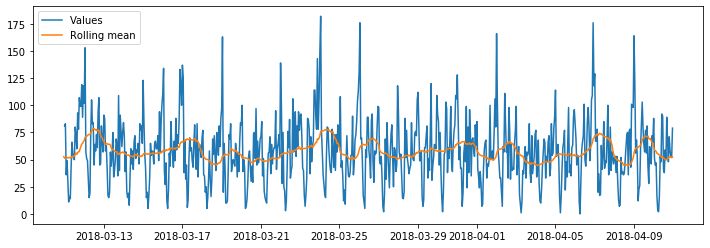

In [957]:
# за месяц
rolling_mean_plot(df['2018-03-10':'2018-04-10'], 24)

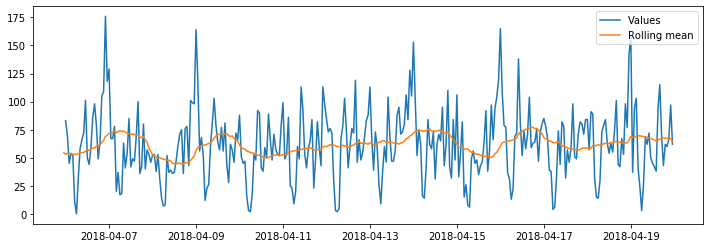

In [958]:
# за 2 недели
rolling_mean_plot(df['2018-04-05':'2018-04-19'], 24)

На графике за месяц видна некая недельная тенденция (18, 25, 2, 9 числа). При рассмотрении графика за 2 недели эта тенденция действительно прослеживается (7-9, 14-16 числа).

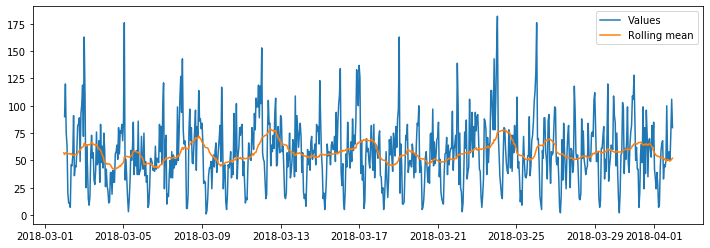

In [959]:
# за первую половину марта
rolling_mean_plot(df['2018-03-01':'2018-04-01'], 24)

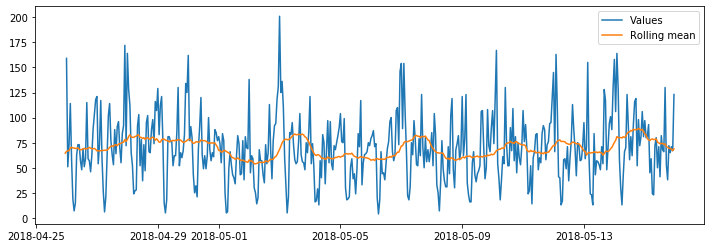

In [960]:
# за первую половину мая
rolling_mean_plot(df['2018-04-25':'2018-05-15'], 24)

Праздничные дни также привносят вклад в число заказов. 

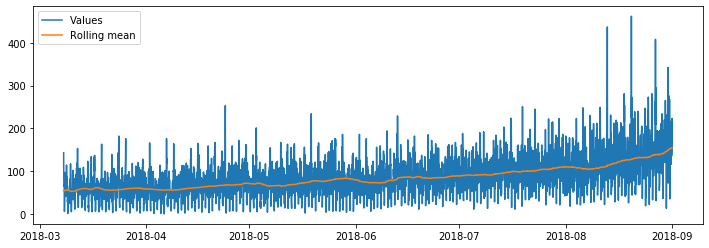

In [961]:
# за все время
rolling_mean_plot(df, 24*7)

На графике за полгода (весь доступный период) видно, что число заказов с течением времени растет

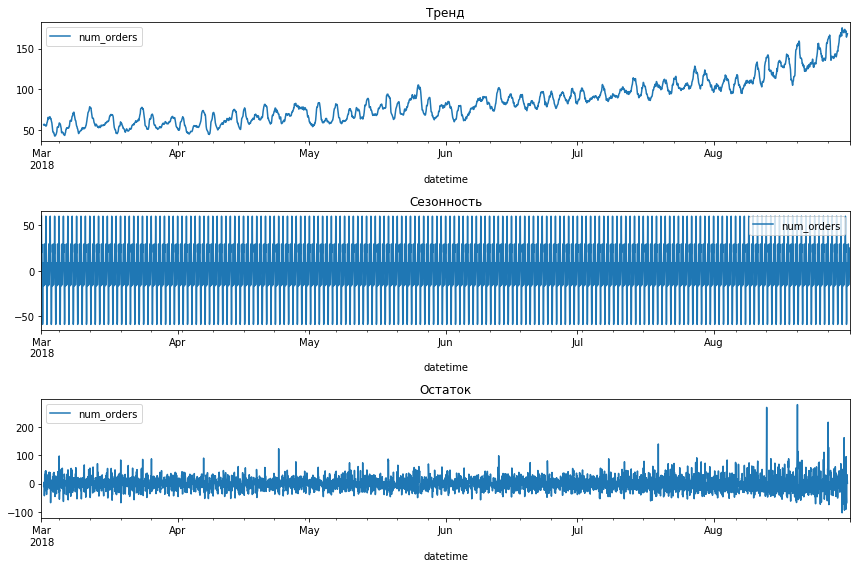

In [962]:
# декомпозиция
decomposed = seasonal_decompose(df)
#построение графиков
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Данные сильнее зашумлены в августе

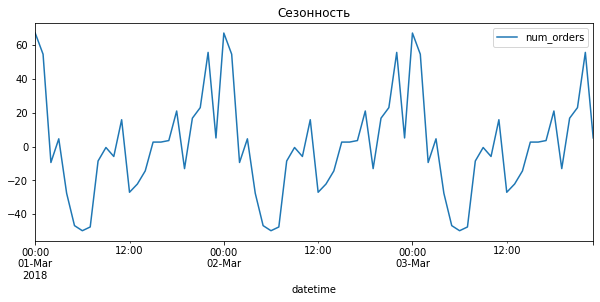

In [963]:
# сезонность в пределах нескольких дней
seasonal_decompose(df['2018-03-01' : '2018-03-03']).seasonal.plot(figsize=(10, 4))
plt.title('Сезонность')
plt.show()

Отчетливо прослеживается сезонность за сутки 

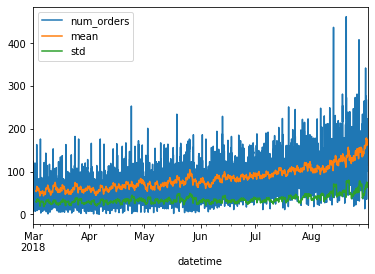

In [964]:
df['mean'] = df['num_orders'].rolling(40).mean()
df['std'] = df['num_orders'].rolling(40).std()
df.plot()
plt.show()

Ряд нестационарный. Используем разности временного ряда, поскольку они более стационарны, чем сам ряд.

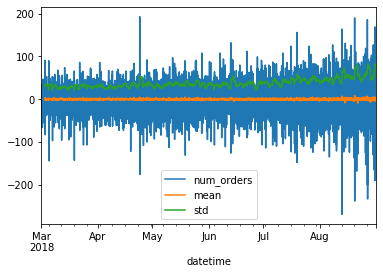

In [965]:
df -= df.shift()
df['mean'] = df['num_orders'].rolling(40).mean()
df['std'] = df['num_orders'].rolling(40).std()
df.plot()
plt.show()

Среднее стало более стабильно.

In [966]:
df = df.drop(['mean', 'std'], axis=1)

Сгенирируем признаки

In [967]:
def make_features(df, max_lag, rolling_mean_size):
    
    # календарные признаки
    #df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    # отстающие значения
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    #скользящее среднее
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [968]:
make_features(df, 24, 3)

## Обучение

In [969]:
# RMSE (потому что здесь не работает squared=False)
def rmse(true, predicted):
    return mean_squared_error(true, predicted)**.5

rmse_score = make_scorer(rmse, greater_is_better=False)

In [970]:
# функция для построения графиков
def visualization(target, predict): 
    """построение графика истинных значений (синий) и предсказанных (красный)"""
    plt.figure(figsize=(12, 6))
    plt.plot(predict, "r", label="prediction", alpha=0.5)
    plt.plot(target.values, label="actual", alpha=0.5)
    plt.legend()
    plt.show()

Разобьем на тестовую (10%), обучающую (80%) и валидационную (80%). Можно было бы использовать [кросс-валидацию](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) с некоторыми доработками, но ради экономии времени, будем использовать валидационную выборку.

In [971]:
other, test = train_test_split(df, shuffle=False, test_size=0.1)

print("Обучающая+валидационная:", other.shape)
print("с", other.index.min(), "до", other.index.max())
print("Тестовая:", test.shape)
print("с",  test.index.min(), "до",  test.index.max())

Обучающая+валидационная: (3974, 29)
с 2018-03-01 00:00:00 до 2018-08-13 13:00:00
Тестовая: (442, 29)
с 2018-08-13 14:00:00 до 2018-08-31 23:00:00


In [972]:
train, valid = train_test_split(other, shuffle=False, test_size=0.1)

print("Обучающая:", train.shape)
print("с", train.index.min(), "до", train.index.max())
print("Валидационная:", valid.shape)
print("с",  valid.index.min(), "до",  valid.index.max())

Обучающая: (3576, 29)
с 2018-03-01 00:00:00 до 2018-07-27 23:00:00
Валидационная: (398, 29)
с 2018-07-28 00:00:00 до 2018-08-13 13:00:00


In [973]:
# удаление, образовавшихся строк с пропусками
train = train.dropna()

In [974]:
# выделение целевого признака
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [975]:
# для подбора числа отстающих значений и окна скользящего среднего: 24 3
model = LinearRegression()
model.fit(features_train, target_train)
predict_train = model.predict(features_train)
predict_test = model.predict(features_test)
print("RMSE обучающей выборки:", rmse(target_train, predict_train))
print("RMSE тестовой выборки: ", rmse(target_test, predict_test))

RMSE обучающей выборки: 24.836195480354224
RMSE тестовой выборки:  45.13530875545483


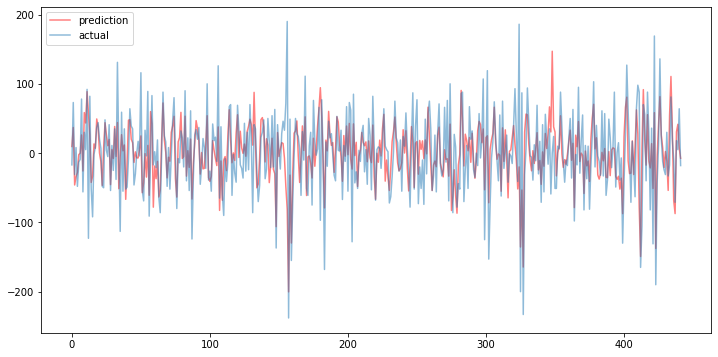

In [976]:
visualization(target_test, predict_test)

Отмасштабируем признаки, в данном случае это существенно не влияет на работу моделей

In [977]:
columns = features_train.columns

In [978]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train), columns=columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns=columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=columns)

Построим модели для подбора гиперпараметров и нахождения лучшей 

In [979]:
# Линейная регрессия
def linear_reg():
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    result = rmse(target_valid, predictions)
    
    predictions_train = model.predict(features_train)
    result_train = rmse(target_train, predictions_train)
    
    return [result, model, result_train]

In [980]:
# Гребневая 
def ridge():
    best_model = None
    best_result = 10**5
    
    for alpha in [0.1, 1, 10, 100]:
        model = Ridge(alpha=alpha, random_state=123)
        model.fit(features_train, target_train)
        
        predictions = model.predict(features_valid)
        result = rmse(target_valid, predictions)
        predictions_train = model.predict(features_train)
        result_train = rmse(target_train, predictions_train)
    
        if result < best_result:
            best_result = result
            best_model = model
            
    return [best_result, best_model, result_train]

In [985]:
# Лассо 
def lasso():
    best_model = None
    best_result = 10**5
    
    for alpha in [0.1, 0.4, 0.6, 0.8, 1]:
        model = Lasso(alpha=alpha, random_state=123)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = rmse(target_valid, predictions)
        predictions_train = model.predict(features_train)
        result_train = rmse(target_train, predictions_train)

        if result < best_result:
            best_result = result
            best_model = model
            
    return [best_result, best_model, result_train]

In [986]:
# k ближайших соседей
def neighbor():
    best_model = None
    best_result = 10**5
    
    for n in [3, 6, 9, 12, 24]:
        model = KNeighborsRegressor(n_neighbors=n)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = rmse(target_valid, predictions)
        predictions_train = model.predict(features_train)
        result_train = rmse(target_train, predictions_train)

        if result < best_result:
            best_result = result
            best_model = model        

    return [best_result, best_model, result_train]

In [987]:
# Случайный лес
def forest():
    best_model = None
    best_result = 10**5
    
    for depth in [5, 7, 9]:
        for n in range(12, 25, 2):
            model = RandomForestRegressor(random_state=12345, 
                                          n_estimators=n, 
                                          max_depth=depth
                                          )
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = rmse(target_valid, predictions)
            
            predictions_train = model.predict(features_train)
            result_train = rmse(target_train, predictions_train)
        
            if result < best_result:
                best_result = result
                best_model = model
            
    return [best_result, best_model, result_train]


In [988]:
def cat_boost():
    best_model = None
    best_result = 10**5

    for rate in [0.2, 0.4, 0.6, 1]:
        for depth in [5, 7, 9]:
            for n in [10, 20, 40]:
                model = CatBoostRegressor(verbose=False, 
                                          random_state=1, 
                                          loss_function='RMSE', 
                                          iterations=n, 
                                          learning_rate=rate, 
                                          max_depth=depth)
                model.fit(features_train, target_train, verbose=False) 
                predictions = model.predict(features_valid, verbose=False)
                result = rmse(target_valid, predictions)
                predictions_train = model.predict(features_train)
                result_train = rmse(target_train, predictions_train)

                if result < best_result:
                    best_result = result
                    best_model = model
            
    return [best_result, best_model, result_train]

In [989]:
def light_gbm():   
    best_model = None
    best_result = 10**5
    
    for rate in [0.2, 0.5, 1]:
        for depth in [7, 9, 11]:
            for n in [3, 5, 9, 11]:
                model = LGBMRegressor(random_state=1, 
                                      learning_rate = 0.5, 
                                      max_depth = depth, 
                                      n_estimators = n)
                model.fit(features_train, target_train, verbose=False) 
                predictions = model.predict(features_valid)
                result = rmse(target_valid, predictions)
                predictions_train = model.predict(features_train)
                result_train = rmse(target_train, predictions_train)


                if result < best_result:
                    best_result = result
                    best_model = model

    return [best_result, best_model, result_train]

In [990]:
# функция для поиска лучшей модели
def model_search():
    """
    Вызывает функции моделей из списка models, 
    формирует таблицу best_models с названиями и RMSE моделей с подогнанными гиперпараметрами,
    выводит графики сравнения предсказазанных и истинных значений на валидационной выборке для каждой модели из списка models,
    возвращает таблицу best_models и модель с лучшим RMSE на валидационной выборке
    """
    best_model = None
    best_result = 10**7
    
    models = [linear_reg(), lasso(), ridge(), neighbor(), forest(), light_gbm(), cat_boost()]
    best_models = pd.DataFrame([], columns=['model', 'RMSE'])
    
    for model in models:
        best_models.loc[len(best_models.index)] = [model[1].__class__.__name__, model[0]]
        
        predict_valid = model[1].predict(features_valid)
        print("{:^100}".format(model[1].__class__.__name__))
        visualization(target_valid, predict_valid)
        
        if model[0] < best_result:
            best_result = model[0]
            best_model = model[1]

    return best_models, best_model

                                          LinearRegression                                          


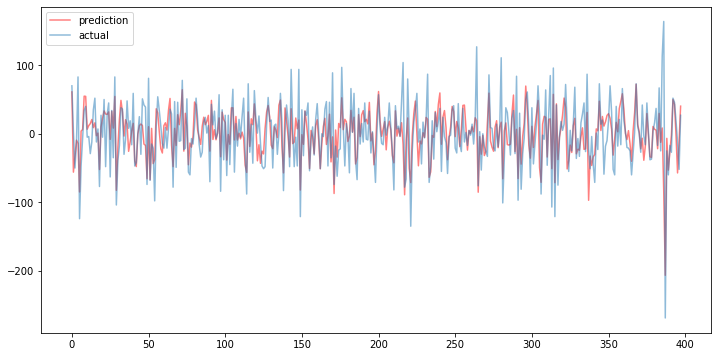

                                               Lasso                                                


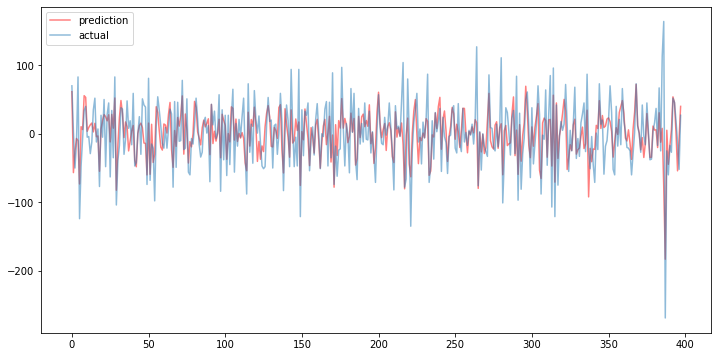

                                               Ridge                                                


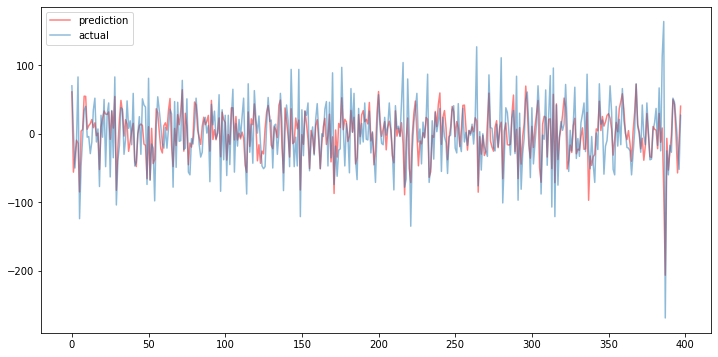

                                        KNeighborsRegressor                                         


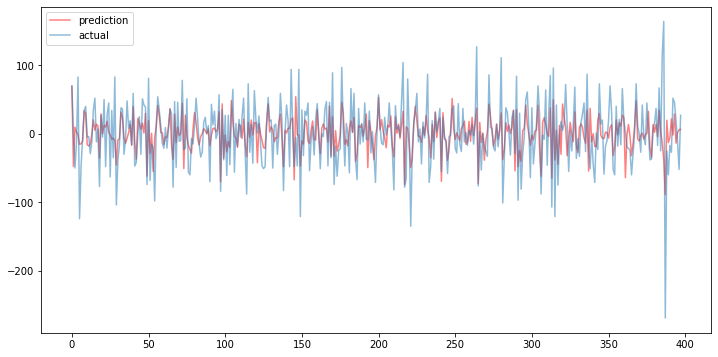

                                       RandomForestRegressor                                        


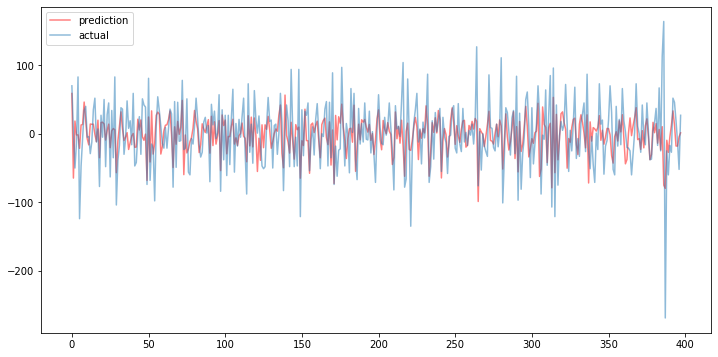

                                           LGBMRegressor                                            


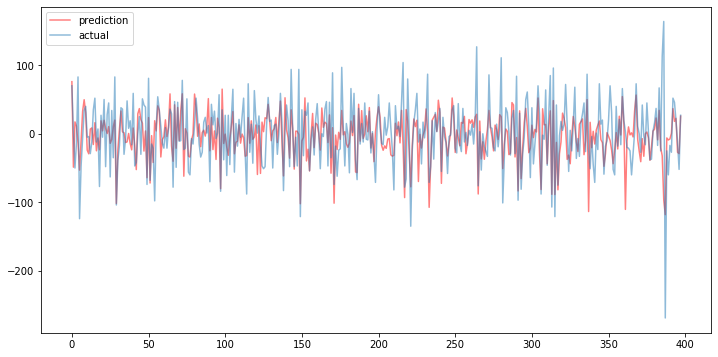

                                         CatBoostRegressor                                          


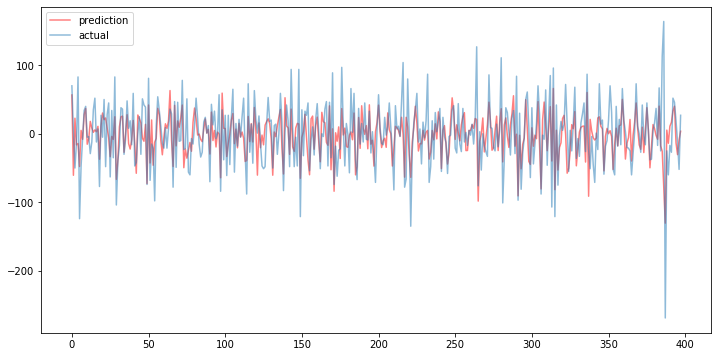

CPU times: user 1min 5s, sys: 5.36 s, total: 1min 11s
Wall time: 1min 32s


In [991]:
%%time
table, best_model = model_search()

In [992]:
# сравнение различных моделей
table

,model,RMSE
0,LinearRegression,34.370000
1,Lasso,34.811141
2,Ridge,34.371272
3,KNeighborsRegressor,36.663753
4,RandomForestRegressor,38.980630
5,LGBMRegressor,38.838025
6,CatBoostRegressor,36.937497


In [993]:
# модель с наименьшим RMSE на валидационной выборке
print('Лучший результат у модели', best_model.__class__.__name__)
print('с параметрами:', best_model.get_params())

Лучший результат у модели LinearRegression
с параметрами: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


## Тестирование

In [994]:
best_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

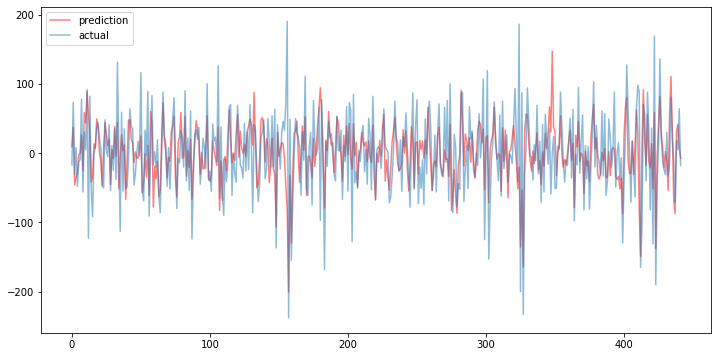

In [995]:
predictions = best_model.predict(features_test)
visualization(target_test, predictions)
result = rmse(target_test, predictions)

In [996]:
print("RMSE лучшей модели на тестовой выборке", round(result, 3))

RMSE лучшей модели на тестовой выборке 45.135


## Вывод

В ходе решения задачи о построении модели для прогнозрования количества заказов такси на следующий час были проделны следующие шаги:

1. данные загружены, проведено ресемплирование по одному часу
2. данные проанализированы:
    - сезонность суточная: минимум в 6:00, максимум около 00:00
    - небольшая недельная сезонность
    - увеличение заказов в праздничные дни.
    - тренд возрастающий
3. ряд преобразован: использованы разности временного ряда, поскольку они более стационарны, чем сам ряд.
4. сгенерированы признаки:
    - календарные
    - отстающие значения: 24
    - скользящее среднее с окном равным 3
5. выделена тестовая выборка (10%)
6. выделен целевой признак
7. построены разные модели и подобраны геперпараметры
8. найдена лучшая модель

In [997]:
best_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Лучшая модель протестирована

In [998]:
print("RMSE лучшей модели на тестовой выборке", round(result, 3))

RMSE лучшей модели на тестовой выборке 45.135
